# Classification overview



In [13]:
# how many images had at least one face detected
import pandas as pd

df = pd.read_csv('YOLO-optimizer/face_detection_results.csv')
df.groupby(['name', 'confidence_setting']).face_detected.apply(lambda x: (x != 0).sum()).reset_index()


,name,confidence_setting,face_detected
0,yolov8l,0.1,399
1,yolov8l,0.2,321
2,yolov8l,0.3,289
3,yolov8l,0.4,273
4,yolov8l,0.5,254
5,yolov8l,0.6,240
6,yolov8l,0.7,216
7,yolov8l,0.8,308
8,yolov8l,0.9,0
9,yolov8m,0.1,389


In [12]:
# how many images had more than 1 face detected grouped by confidence setting and name

df.groupby(['name', 'confidence_setting']).face_detected.apply(lambda x: (x > 1).sum()).reset_index()

,name,confidence_setting,face_detected
0,yolov8l,0.1,0
1,yolov8l,0.2,0
2,yolov8l,0.3,0
3,yolov8l,0.4,0
4,yolov8l,0.5,0
5,yolov8l,0.6,0
6,yolov8l,0.7,0
7,yolov8l,0.8,0
8,yolov8l,0.9,0
9,yolov8m,0.1,0


In [17]:
# hide the warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import precision_recall_fscore_support
def calculate_metrics(y_true, y_pred):
  """
  Calculates precision, recall, F1-score, and miss rate for a given y_true and y_pred pair.

  Args:
      y_true: Ground truth labels (1D array).
      y_pred: Predicted labels from an algorithm (1D array).

  Returns:
      precision: Precision score.
      recall: Recall score.
      f1_score: F1-score.
      miss_rate: Miss rate.
  """
  precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred)

  # Miss rate for the "face" class (assuming class index 0)
  # miss_rate = 1 - recall[0]

  return precision[1], recall[1], f1_score[1], support[1]

def create_binary_vectors(df_truth, df_algo):
    # Group by 'path' and check if at least one face was detected for each 'path'
    truth_vector = (df_truth.groupby('path')['face_detected'].sum() > 0).astype(int)
    algo_vector = (df_algo.groupby('path')['face_detected'].sum() > 0).astype(int)

    # Align the vectors
    truth_vector, algo_vector = truth_vector.align(algo_vector, join='outer')

    # Fill NaN values with 0 (no face detected)
    truth_vector.fillna(0, inplace=True)
    algo_vector.fillna(0, inplace=True)

    return truth_vector, algo_vector
# load or construct ground truth dataframe
# for demo purposes we will designate model yolov8n, confidence 0.7 as the ground truth
# create empty dataframe for results
df_results = pd.DataFrame(columns=['name', 'confidence_setting', 'precision', 'recall', 'f1_score', 'support'])

df_ground_truth = df[(df['name'] == 'yolov8l') & (df['confidence_setting'] == 0.5)]

# how many rows in df_ground_truth have non-zero face_detected values
df_ground_truth['face_detected'].astype(bool).sum(axis=0)

confidence_values = [d for d in df['confidence_setting'].unique()]
# iterate through all unique confidence settings and models
for model_name in df.name.unique():
    for confidence in confidence_values:
        # filter the dataframe for the model and confidence setting
        df_model_algo = df[(df['name'] == model_name) & (df['confidence_setting'] == confidence)]
        # sort the dataframe by path
        df_model_algo = df_model_algo.sort_values('path')
        # Max possible detection (including 0)
        # n = max(df_ground_truth['face_detected'].max(), df_model_algo['face_detected'].max())+1
        # create the binary vectors
        truth_vector, algo_vector = create_binary_vectors(df_ground_truth, df_model_algo)
        
        df_ground_truth['face_detected'].astype(bool).sum(axis=0)
        df_model_algo['face_detected'].astype(bool).sum(axis=0)

        # convert series to numpy array
        truth_vector_np = truth_vector.to_numpy()
        algo_vector_np = algo_vector.to_numpy()
        
        # from sklearn.metrics import confusion_matrix
        # cm = confusion_matrix(truth_vector_np, algo_vector_np)
        # print(cm)

        # calculate the metrics
        precision, recall, f1_score, support = calculate_metrics(truth_vector_np, algo_vector_np)
        # store the metrics in dataframe using pd.concat
        df_results = pd.concat([df_results, pd.DataFrame({'name': [model_name], 'confidence_setting': [confidence], 'precision': [precision], 'recall': [recall], 'f1_score': [f1_score], 'support': [support]})])

# arrange df_results by f1_score
df_results.sort_values(by='f1_score', ascending=False)


,name,confidence_setting,precision,recall,f1_score,support
0,yolov8l,0.5,1.000000,1.000000,1.000000,254
0,yolov8l,0.6,1.000000,0.944882,0.971660,254
0,yolov8l,0.4,0.930403,1.000000,0.963947,254
0,yolov8m,0.6,0.978723,0.905512,0.940695,254
0,yolov8l,0.3,0.878893,1.000000,0.935543,254
0,yolov8m,0.5,0.929412,0.933071,0.931238,254
0,yolov8l,0.7,1.000000,0.850394,0.919149,254
0,yolov8m,0.7,0.990868,0.854331,0.917548,254
0,yolov8m,0.4,0.882784,0.948819,0.914611,254
0,yolov8n,0.5,0.934156,0.893701,0.913481,254


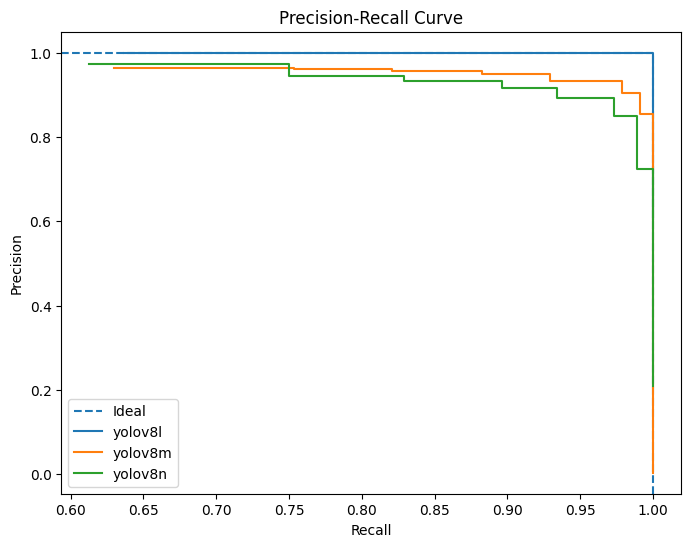

In [18]:
def pr_curve_plot(df):
    """
    Args:
        df (pandas.DataFrame): DataFrame with columns 'name', 'confidence_setting', 'precision', 'recall'
    """
    
    import matplotlib.pyplot as plt
    from sklearn.metrics import PrecisionRecallDisplay
    
    _, ax = plt.subplots(figsize=(8, 6))
    plt.axhline(1,0,0.955, linestyle='--', label='Ideal')
    plt.axvline(1,0,0.955, linestyle='--')
    plt.title('Precision-Recall Curve')
    plt.plot()
    
    # Get the unique names of the algorithms
    names = df['name'].unique()

    # For each algorithm
    for name in names:
        # Filter the DataFrame to only include rows for this algorithm
        df_filtered = df[df['name'] == name]
        
        # Sort the DataFrame by confidence_setting
        df_sorted = df_filtered.sort_values('confidence_setting')
        
        # Plot the precision-recall curve
        PrecisionRecallDisplay(df_sorted['recall'], df_sorted['precision']).plot(ax=ax, name=name)

# filter row in df_results where f1_score is greater 1.00
df_results_filtered = df_results[df_results['f1_score'] < 0.999]
df_results_filtered = df_results_filtered[df_results_filtered['f1_score'] > 0.00]
# sort the dataframe by f1_score
df_results_filtered = df_results_filtered.sort_values(by='f1_score', ascending=False)
# Call the function
pr_curve_plot(df_results_filtered)